<a href="https://colab.research.google.com/github/abs-git/GNN/blob/main/GNN_for_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from IPython.display import clear_output 
torch_version = torch.__version__
print("Torch version: ", torch_version)
pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric
clear_output()

In [ ]:
!pip install torch-geometric-temporal
clear_output()

## Data load

In [ ]:
# Los Angeles Metropolitan traffic dataset
# 207 loop detectors on the highway

from torch_geometric_temporal.dataset import METRLADatasetLoader

data_loader = METRLADatasetLoader()

# input sequence lenght : 12 / output sequence lenght : 12
dataset = data_loader.get_dataset(num_timesteps_in = 12, num_timesteps_out= 12)
dataset2 = data_loader.get_dataset(num_timesteps_in = 6, num_timesteps_out= 6)


In [ ]:
import numpy as np

print(dataset)

print(len(list(dataset)))
list(dataset)[:5]

34249


[Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12]),
 Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12]),
 Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12]),
 Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12]),
 Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])]

In [ ]:
# nNodes : 207
# node feature : (speed, time)
# 12 timesteps per bucket : (12 * 5 min)
# label (y) : next 12 timesteps (speed)
# edge_attr : distances between sensors 
# node regression

print(next(iter(dataset)))
print(next(iter(dataset2)))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])
Data(x=[207, 2, 6], edge_index=[2, 1722], edge_attr=[1722], y=[207, 6])


[0.731095016002655, 0.5970844030380249, 0.43421027064323425, 0.6575608849525452, 0.6383185386657715, 0.6355695128440857, 0.5091187357902527, 0.4465804696083069, 0.632133424282074, 0.588837742805481, 0.5036208629608154, 0.4218400716781616, 0.5750930309295654, 0.7187248468399048, 0.5476036071777344, 0.4527655839920044, 0.5860887169837952, 0.6073930263519287, 0.687799334526062, 0.580591082572937, 0.6025824546813965, 0.7549516558647156, 0.723535418510437, 0.4898761510848999]


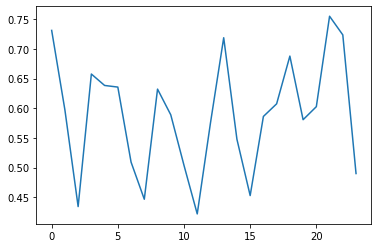

In [ ]:
# Visualizer
import seaborn as sns

node_idx = 7    # sensor number
hours = 24      # duration

node_labels = []
for bucket in list(dataset)[:hours]:
  # print(bucket)
  # print(bucket.y)
  # print(bucket.y.shape)
  # print(bucket.y[1])
  # print(bucket.y[1][0])

  node_labels.append(bucket.y[node_idx][0].item())

print(node_labels)

sns.lineplot(data = node_labels)

In [ ]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio =  0.8)

print("Train buckets : {}".format(len(list(train_dataset))))
print("Test buckets : {}".format(len(list(test_dataset))))

Train buckets : 27399
Test buckets : 6850


## Model

In [ ]:
# Attention Temporal Graph Convolutional Network
# based on T-GCN

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN


class TemporalGNN(nn.Module):
  def __init__(self, node_features, periods):
    super(TemporalGNN, self).__init__()

    # 3 steps single-shot prediction
    self.tgnn = A3TGCN(in_channels = node_features, out_channels = 32, periods = periods)

    self.lin = nn.Linear(32, periods)
  
  def forward(self, x, edge_index):

    out = self.tgnn(x, edge_index)
    out = F.relu(out)    
    out = self.lin(out)

    return out


In [ ]:
# x : node features for T time steps
# edge_index : Graph edge indices

model = TemporalGNN(node_features = 2, periods = 12)

model

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (lin): Linear(in_features=32, out_features=12, bias=True)
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
subset = 2000

model = TemporalGNN(node_features = 2, periods = 12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr =  0.01)

eval_preds = []
eval_targets = []

for epoch in range(5):

  # train task
  model.train()
  optimizer.zero_grad()

  train_loss = 0
  train_step = 0
  for batch in train_dataset:
    batch.to(device)
    y_hat = model(batch.x, batch.edge_index)
    train_loss = train_loss + torch.mean((y_hat - batch.y) ** 2)    # mse
    train_step += 1

  train_loss = train_loss / (train_step + 1)
  train_loss.backward()
  optimizer.step()

  # evaluation task
  model.eval()
  eval_loss = 0
  eval_step = 0
  horizon = 288     # horizon/steps = hours (288/12 = 24)


  for batch in test_dataset:
    batch.to(device)
    y_hat = model(batch.x, batch.edge_index)
    eval_loss = eval_loss + torch.mean((y_hat - batch.y) ** 2)

    eval_targets.append(batch.y)
    eval_preds.append(y_hat)
    eval_step += 1

  eval_loss = eval_loss / (eval_step + 1)

  print('Train MSE : {:.4f}'.format(train_loss))
  print('Eval MSE  : {:.4f}'.format(eval_loss.item()))


In [ ]:
# Visualization
import matplotlib.pyplot as plt

sensor_num = 100
timestep = 10

predicted = np.asarray([eval_preds[sensor_num][timestep].detach().cpu().numpy() for pred in eval_preds])
targets = np.asarray([eval_targets[sensor_num][timestep].detach().cpu().numpy() for target in eval_targets])

plt.figure(figsize = (20,5))
plt.plot(predicted)
plt.plot(targets)
